In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import pandas as pd
from brian2 import *
import librosa
import glob
import soundfile as sf
from IPython.display import HTML, display, clear_output
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, mean_squared_error
from scipy.stats import pearsonr
from brian2 import prefs
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, Flatten, Dense
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split


# Проверка доступности GPU для вычислений с CUDA
gpu_devices = tf.config.list_physical_devices('GPU')
if len(gpu_devices) > 0:
    print("CUDA доступна. Запускаем вычисления на GPU с использованием cuda_standalone.")
    import brian2cuda
    set_device("cuda_standalone")
else:
    print("CUDA не доступна. Вычисления на GPU не будут выполнены.")
    # При необходимости можно использовать альтернативное устройство, например, CPU:
    # set_device("cpp_standalone")

prefs.codegen.target = 'cython'

try:
    import IPython.display as ipd
    in_notebook = True
except ImportError:
    in_notebook = False

num_samples = 1000
num_samples_for_mse = 100
num_samples_partial = 3  # Число примеров, для которых мониторим детальную активность

tau = 20*ms
dt = 1*ms
defaultclock.dt = dt

eta = 1e-6 * Hz  
decay = 4e-3
sample_duration = 100*ms
num_time_steps_per_sample = int(sample_duration / dt)
total_duration = num_samples * sample_duration

N_hidden = 400

def load_full_mnist():
    """
    Загрузка полной выборки MNIST (784 входных признака + класс метки [0..9]).
    Нормировка входных пикселей к диапазону [0, 1].
    """
    df = pd.read_csv('mnist_784.csv')
    X = df.iloc[:, 0:784].values / 255.0
    y = df.iloc[:, 784].values  
    return X, y

def extract_useful_signal(signal, sr, top_db=20):
    """
    Удаление тишины в начале и конце сигнала на основе метода librosa.effects.trim.
    Параметр top_db определяет порог в дБ относительно пикового уровня сигнала,
    ниже которого считаться «тишиной».
    """
    # trim возвращает обрезанный сигнал и индексы начала/конца
    trimmed_signal, idx = librosa.effects.trim(signal, top_db=top_db)
    return trimmed_signal

def load_preprocess_audio(num_samples, target_length=5000):
    """
    Загрузка аудиофайлов, удаление тишины с помощью extract_useful_signal,
    нормировка их в диапазон [0, 1], 
    выравнивание длины до target_length путём усечения или дополнения нулями.
    """
    audio_files = glob.glob('free-spoken-digit-dataset/recordings/*.wav')
    np.random.shuffle(audio_files)
    selected_files = audio_files[:num_samples]
    
    X_audio_list = []
    sr_list = []
    digits_audio = []

    for file in selected_files:
        base_name = file.split('/')[-1]
        digit_str = base_name.split('_')[0]
        audio_digit = int(digit_str)
        digits_audio.append(audio_digit)
         
        signal, sr = librosa.load(file, sr=None)
        # Удаляем тишину слева и справа
        extract = extract_useful_signal(signal, sr, top_db=20)            
        sr_list.append(sr)

        # Усечение или дополнение до target_length
        if len(extract) > target_length:
            signal = extract[:target_length]
        else:
            signal = np.pad(extract, (0, target_length - len(extract)), 'constant')
        
        # Масштабируем сигнал в диапазон [0, 1]
        min_val, max_val = np.min(signal), np.max(signal)
        # Во избежание деления на 0 добавляем небольшую константу
        if max_val - min_val < 1e-12:
            signal = np.zeros_like(signal)  # если сигнал фактически нулевой
        else:
            signal = (signal - min_val) / (max_val - min_val)
        
        X_audio_list.append(signal)
    
    X_audio = np.array(X_audio_list)
    sr = sr_list[0] if sr_list else 22050

    unique_digits = np.unique(digits_audio)
    if len(unique_digits) < 2 and num_samples > 1:
        raise ValueError("Недостаточно разнообразных классов. Увеличьте количество файлов или перезапустите.")

    return X_audio, sr, digits_audio

def match_images_to_audio_digits(X, y, digits_audio, num_samples):
    """
    Для каждой аудиозаписи выбираем случайное изображение с той же цифрой (в MNIST).
    Возвращаем матрицу изображений с такой же длиной, что и X_audio.
    """
    matched_images = []
    for d in digits_audio:
        indices = np.where(y == d)[0]
        if len(indices) == 0:
            raise ValueError(f"Не найдено изображений в MNIST с цифрой {d}")
        idx = np.random.choice(indices)
        matched_images.append(X[idx])
    matched_images = np.array(matched_images)
    return matched_images

def prepare_input_data(X_image, X_audio, num_time_steps_per_sample):
    """
    
    Формируем массивы признаков (признаки изображений и аудио) 
    во временном формате для подачи в TimedArray (Brian2).
    """
    num_samples_local = X_image.shape[0]
    N_input_image = X_image.shape[1]
    N_input_audio = X_audio.shape[1]
    
    total_time_steps = num_samples_local * num_time_steps_per_sample
    input_image_array = np.zeros((total_time_steps, N_input_image))
    input_audio_array = np.zeros((total_time_steps, N_input_audio))
    
    for i in range(num_samples_local):
        start_idx = i * num_time_steps_per_sample
        end_idx = (i + 1) * num_time_steps_per_sample
        input_image_array[start_idx:end_idx, :] = X_image[i]
        input_audio_array[start_idx:end_idx, :] = X_audio[i]

    print(input_image_array.shape)
    print(input_audio_array.shape)
    Image_ext = TimedArray(input_image_array, dt=dt)
    Audio_ext = TimedArray(input_audio_array, dt=dt)
    
    return Image_ext, Audio_ext
    
X_full, y_full = load_full_mnist()
X_audio, sr, digits_audio = load_preprocess_audio(num_samples=num_samples, target_length=5000)
X_image = match_images_to_audio_digits(X_full, y_full, digits_audio, num_samples=num_samples)
Image_ext, Audio_ext = prepare_input_data(X_image, X_audio, num_time_steps_per_sample)

N_input_image = 784
N_input_audio = X_audio.shape[1]

print("Кол-во нейронов для аудио", N_input_audio)
print("Размерность аудио-признаков:", X_audio.shape)
print("Пример меток (цифры из аудио):", digits_audio[:10])
print("Размерность набора изображений:", X_image.shape)

2025-03-30 23:52:35.317189: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-30 23:52:35.462021: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1743367955.513464     610 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1743367955.528989     610 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1743367955.648308     610 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

CUDA доступна. Запускаем вычисления на GPU с использованием cuda_standalone.
(100000, 784)
(100000, 5000)
Кол-во нейронов для аудио 5000
Размерность аудио-признаков: (1000, 5000)
Пример меток (цифры из аудио): [7, 1, 7, 0, 4, 2, 9, 6, 0, 1]
Размерность набора изображений: (1000, 784)


In [2]:
start_scope()

w_input_image_hidden_init = np.random.randn(N_input_image * N_hidden)*0.01
w_input_audio_hidden_init = np.random.randn(N_input_audio * N_hidden)*0.01
w_hidden_image_input_init = np.random.randn(N_hidden * N_input_image)*0.01
w_hidden_audio_input_init = np.random.randn(N_hidden * N_input_audio)*0.01

threshold_value = 'v > 0.5'
threshold_value_3 = 'v > 0.3'

input_image_neurons = NeuronGroup(N_input_image, '''
    dv/dt = (-v + V_error) / tau : 1
    V_error = Image_ext(t, i) - v + V_feedback : 1
    V_feedback : 1
    ''',
    threshold=threshold_value, reset='v = 0', method='euler')

input_audio_neurons = NeuronGroup(N_input_audio, '''
    dv/dt = (-v + V_error) / tau : 1
    V_error = Audio_ext(t, i) - v + V_feedback : 1
    V_feedback : 1
    ''',
    threshold=threshold_value, reset='v = 0', method='euler')

hidden_neurons = NeuronGroup(N_hidden, '''
    dv/dt = (-v + V_input_image + V_input_audio) / tau : 1
    V_input_image : 1
    V_input_audio : 1
    ''',
    threshold=threshold_value_3, reset='v = 0', method='euler')

syn_input_image_hidden = Synapses(input_image_neurons, hidden_neurons, '''
    V_input_image_post = w * v_pre : 1 (summed)
    dw/dt = eta * (v_post * v_pre - w * decay) : 1 (clock-driven)
    ''')
syn_input_image_hidden.connect()
syn_input_image_hidden.w = w_input_image_hidden_init 

syn_input_audio_hidden = Synapses(input_audio_neurons, hidden_neurons, '''
    V_input_audio_post = w * v_pre : 1 (summed)
    dw/dt = eta * (v_post * v_pre - w * decay) : 1 (clock-driven)
    ''')
syn_input_audio_hidden.connect()
syn_input_audio_hidden.w = w_input_audio_hidden_init

syn_hidden_image_input = Synapses(hidden_neurons, input_image_neurons, '''
    V_feedback_post = w * v_pre : 1 (summed)
    dw/dt = eta * (v_post * v_pre - w * decay) : 1 (clock-driven)
    ''')
syn_hidden_image_input.connect()
syn_hidden_image_input.w = w_hidden_image_input_init

syn_hidden_audio_input = Synapses(hidden_neurons, input_audio_neurons, '''
    V_feedback_post = w * v_pre : 1 (summed)
    dw/dt = eta * (v_post * v_pre - w * decay) : 1 (clock-driven)
    ''')
syn_hidden_audio_input.connect()
syn_hidden_audio_input.w = w_hidden_audio_input_init

partial_duration = num_samples_partial * sample_duration
remaining_duration = total_duration - partial_duration

mon_hidden = StateMonitor(hidden_neurons, 'v', record=True)
mon_input_image = StateMonitor(input_image_neurons, 'v', record=True)
mon_input_audio = StateMonitor(input_audio_neurons, 'v', record=True)
spikes_input_image = SpikeMonitor(input_image_neurons)
spikes_input_audio = SpikeMonitor(input_audio_neurons)
spikes_hidden = SpikeMonitor(hidden_neurons)

INFO       CUDA installation directory found in standard location: /usr/local/cuda [brian2cuda.utils.gputools]


In [3]:
print("Выполнение симуляции для всех примеров...")
run(total_duration)

# mon_input_image.active = False
# mon_input_audio.active = False
spikes_input_image.active = False
spikes_input_audio.active = False
spikes_hidden.active = False

INFO       No numerical integration method specified for group 'synapses_1', using method 'exact' (took 0.01s). [brian2.stateupdaters.base.method_choice]
WARNING    'dt' is an internal variable of group 'synapses_1', but also exists in the run namespace with the value 1. * msecond. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]
INFO       No numerical integration method specified for group 'synapses_2', using method 'exact' (took 0.00s). [brian2.stateupdaters.base.method_choice]
WARNING    'dt' is an internal variable of group 'synapses_2', but also exists in the run namespace with the value 1. * msecond. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]
INFO       No numerical integration method specified for group 'synapses_3', using method 'exact' (took 0.00s). [brian2.stateupdaters.base.method_choice]
WARNING    'dt' is an internal variable of group 'synapses_3', but also exists in the run namesp

Выполнение симуляции для всех примеров...


INFO       Compiling device code for GPU 0 (NVIDIA GeForce RTX 4070 Ti SUPER) [brian2cuda.utils.gputools]
INFO       Compiling device code for compute capability 8.9 (compiler flags: ['-arch=sm_89']) [brian2cuda.device]
INFO       Using the following preferences for CUDA standalone: [brian2cuda.device]
INFO       	devices.cuda_standalone.SM_multiplier = 1 [brian2cuda.device]
INFO       	devices.cuda_standalone.parallel_blocks = 1 [brian2cuda.device]
INFO       	devices.cuda_standalone.launch_bounds = False [brian2cuda.device]
INFO       	devices.cuda_standalone.syn_launch_bounds = False [brian2cuda.device]
INFO       	devices.cuda_standalone.calc_occupancy = True [brian2cuda.device]
INFO       	devices.cuda_standalone.extra_threshold_kernel = True [brian2cuda.device]
INFO       	devices.cuda_standalone.random_number_generator_type = CURAND_RNG_PSEUDO_DEFAULT [brian2cuda.device]
INFO       	devices.cuda_standalone.random_number_generator_ordering = False [brian2cuda.device]
INFO       	

INFO: _init_arrays() took 0.09861s
INFO: synapses creation took 0.056767s
INFO: synapses_1 creation took 0.401651s
INFO: synapses_2 creation took 0.062458s
INFO: synapses_3 creation took 0.378118s
INFO _run_kernel_statemonitor_codeobject
	1 blocks
	768 threads
	12 registers per thread
	0 bytes statically-allocated shared memory per block
	0 bytes local memory per thread
	2520 bytes user-allocated constant memory
	1.000 theoretical occupancy
INFO _run_kernel_statemonitor_1_codeobject
	2 blocks
	768 threads
	12 registers per thread
	0 bytes statically-allocated shared memory per block
	0 bytes local memory per thread
	2520 bytes user-allocated constant memory
	1.000 theoretical occupancy
INFO _run_kernel_statemonitor_2_codeobject
	7 blocks
	768 threads
	12 registers per thread
	0 bytes statically-allocated shared memory per block
	0 bytes local memory per thread
	2520 bytes user-allocated constant memory
	1.000 theoretical occupancy
INFO _run_kernel_synapses_1_summed_variable_V_input_aud


Анимационная реконструкция для образца изображения 0, цифра: 7


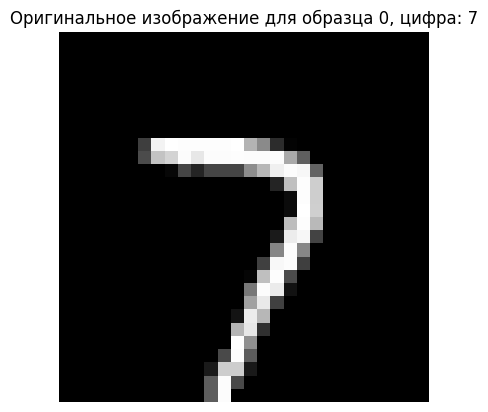

MovieWriter ffmpeg unavailable; using Pillow instead.



Анимационная реконструкция для аудиосэмпла 0, цифра: 7


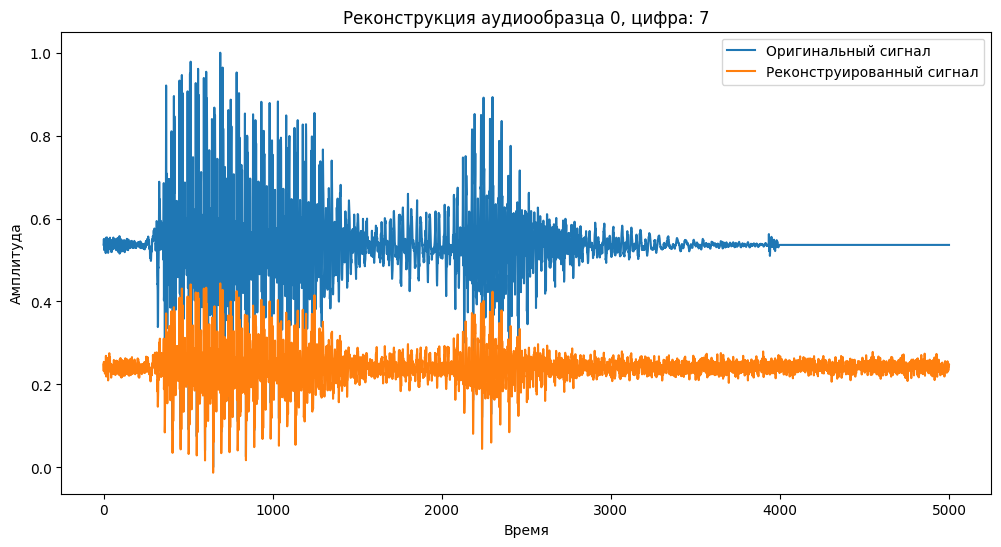

Оригинальный сигнал:


Реконструированный сигнал:



Анимационная реконструкция для образца изображения 1, цифра: 1


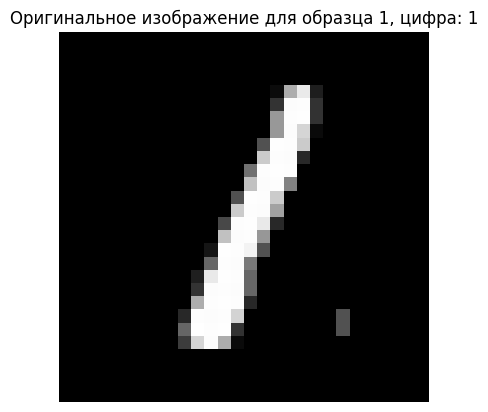

MovieWriter ffmpeg unavailable; using Pillow instead.



Анимационная реконструкция для аудиосэмпла 1, цифра: 1


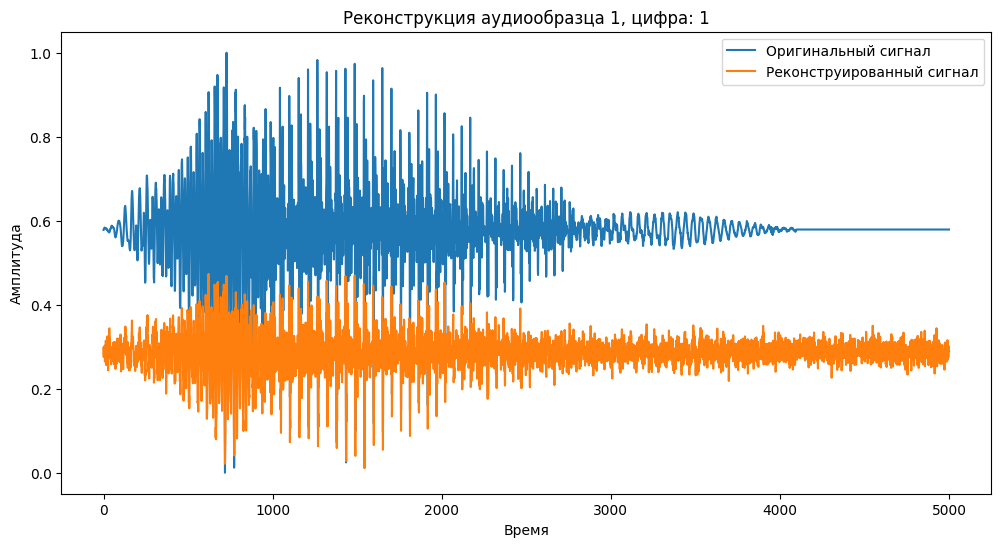

Оригинальный сигнал:


Реконструированный сигнал:



Анимационная реконструкция для образца изображения 2, цифра: 7


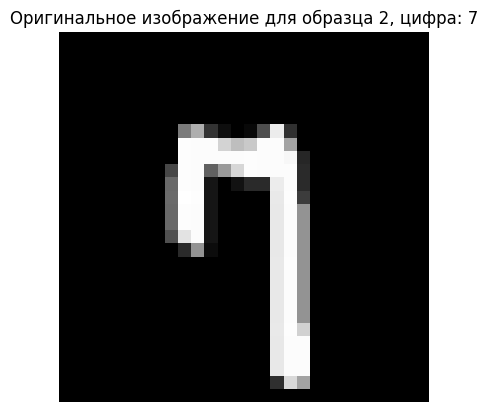

MovieWriter ffmpeg unavailable; using Pillow instead.



Анимационная реконструкция для аудиосэмпла 2, цифра: 7


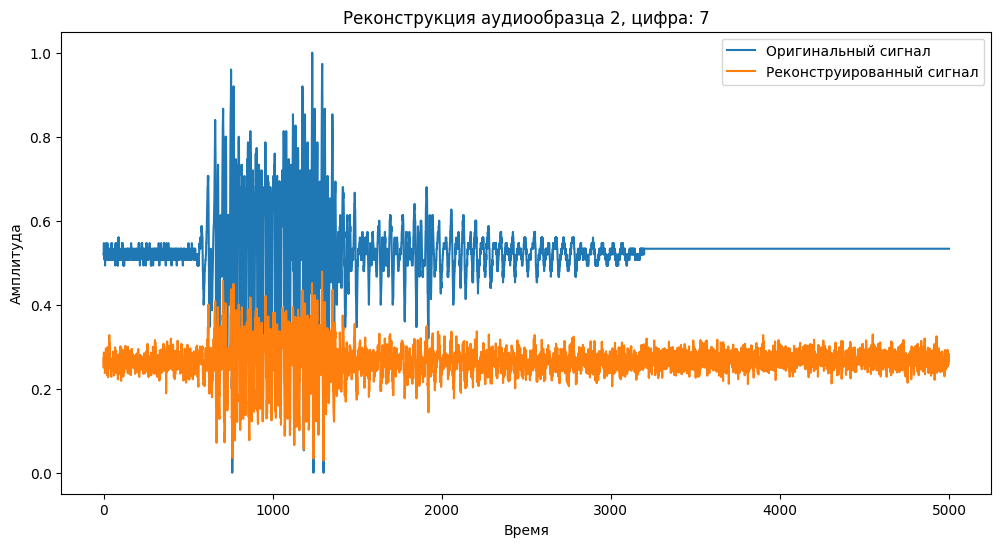

Оригинальный сигнал:


Реконструированный сигнал:


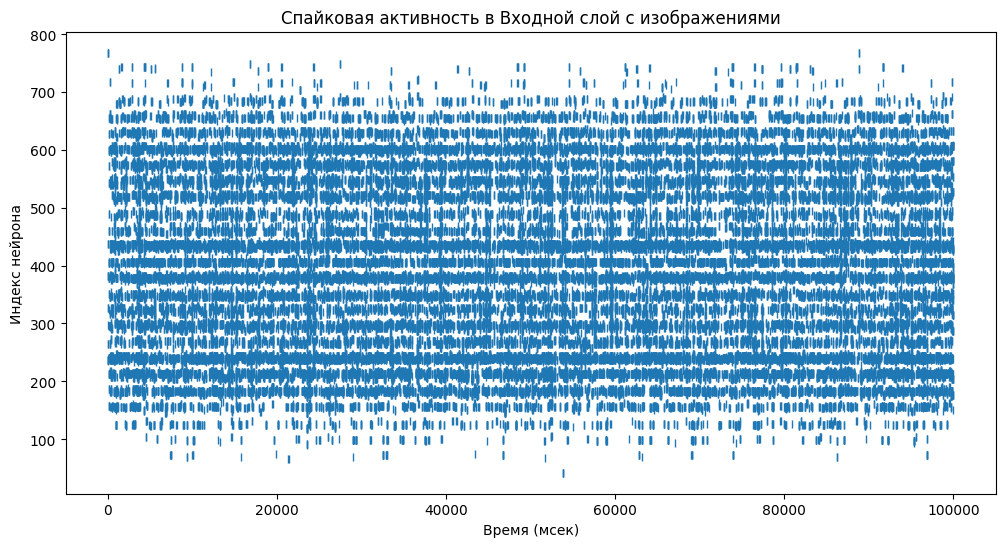

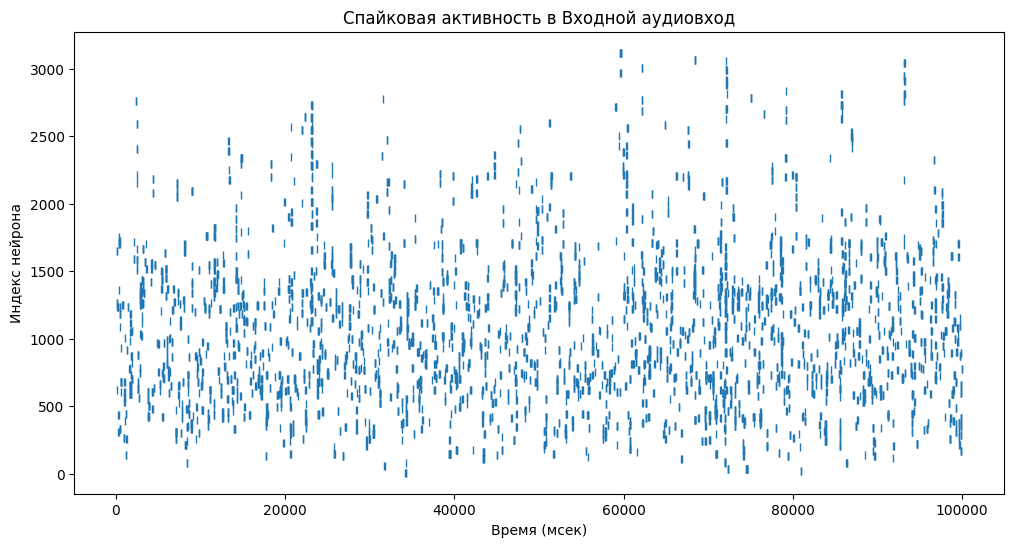

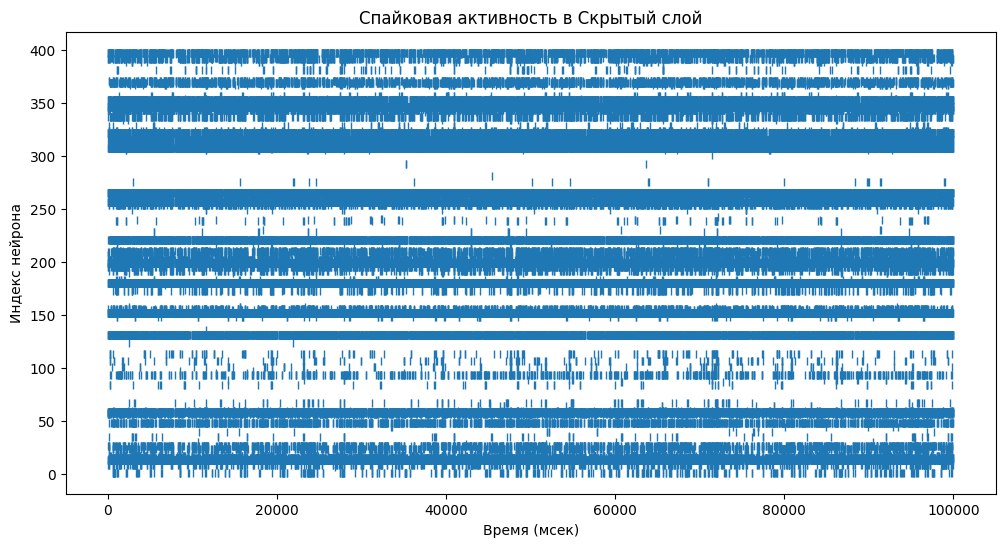

In [4]:
def animate_reconstruction_image(sample_index):
    # Вывод оригинального изображения (предполагается, что X_image содержит исходные данные)
    original_img = X_image[sample_index]
    plt.figure()
    plt.imshow(original_img.reshape(28, 28), cmap='gray')
    plt.title(f'Оригинальное изображение для образца {sample_index}, цифра: {digits_audio[sample_index]}')
    plt.axis('off')
    plt.show()
    
    # Анимация реконструированного изображения
    start_time = sample_index * sample_duration
    end_time = (sample_index + 1) * sample_duration
    start_idx = int(start_time / dt)
    end_idx = int(end_time / dt)
    
    fig = plt.figure()
    plt.axis('off')
    ims = []
    
    for t in range(start_idx, end_idx):
        reconstructed_img = mon_input_image.v[:, t]
        im = plt.imshow(reconstructed_img.reshape(28, 28), cmap='gray', animated=True)
        ims.append([im])
    
    ani = animation.ArtistAnimation(fig, ims, interval=300, blit=True, repeat_delay=1000)
    ani.save(f'animation_sample{sample_index}.gif')
    plt.title(f'Реконструкция образца {sample_index}, цифра: {digits_audio[sample_index]}')
    plt.close(fig)
    display(HTML(ani.to_jshtml()))

def animate_reconstruction_audio(sample_index, audio=True, xlim=None):
    start_time = sample_index * sample_duration
    end_time = (sample_index + 1) * sample_duration
    start_idx = int(start_time / dt)
    end_idx = int(end_time / dt)
    
    # Расчет реконструированного сигнала (усреднение по временной оси)
    reconstructed_signal = mon_input_audio.v[:, start_idx:end_idx].mean(axis=1)
    original_signal = X_audio[sample_index]
    
    plt.figure(figsize=(12, 6))
    plt.plot(original_signal, label='Оригинальный сигнал')
    plt.plot(reconstructed_signal, label='Реконструированный сигнал')
    plt.legend()
    # Заголовок теперь включает метку цифры, соответствующую сэмплу
    plt.title(f'Реконструкция аудиообразца {sample_index}, цифра: {digits_audio[sample_index]}')
    plt.xlabel('Время')
    plt.ylabel('Амплитуда')
    if xlim is not None:
        plt.xlim(xlim[0], xlim[1])
    plt.show()
    
    if audio:
        sf.write(f'original_signal_sample{sample_index}.wav', original_signal, sr)
        sf.write(f'reconstructed_signal_sample{sample_index}.wav', reconstructed_signal, sr)
    
    if in_notebook:
        print("Оригинальный сигнал:")
        display(ipd.Audio(original_signal, rate=sr))
        print("Реконструированный сигнал:")
        display(ipd.Audio(reconstructed_signal, rate=sr))

def plot_spikes(spike_monitor, layer_name):
    plt.figure(figsize=(12, 6))
    plt.plot(spike_monitor.t/ms, spike_monitor.i, '|')
    plt.title(f'Спайковая активность в {layer_name}')
    plt.xlabel('Время (мсек)')
    plt.ylabel('Индекс нейрона')
    plt.show()

for idx in range(num_samples_partial):
    print(f'\nАнимационная реконструкция для образца изображения {idx}, цифра: {digits_audio[idx]}')
    animate_reconstruction_image(idx)
    print(f'\nАнимационная реконструкция для аудиосэмпла {idx}, цифра: {digits_audio[idx]}')
    animate_reconstruction_audio(idx, [500, 600])

plot_spikes(spikes_input_image, 'Входной слой с изображениями')
plot_spikes(spikes_input_audio, 'Входной аудиовход')
plot_spikes(spikes_hidden, 'Скрытый слой')

In [5]:
# ---------- 3. Пример оценки реконструкции (если требуется) ----------
# (Как и раньше, без изменений, если логика осталась та же)
def evaluate_reconstruction_image(sample_index):
    start_time = sample_index * sample_duration
    end_time = (sample_index + 1) * sample_duration
    start_idx = int(start_time / dt)
    end_idx = int(end_time / dt)
    original_img = X_image[sample_index]
    reconstructed_img = mon_input_image.v[:, end_idx-1]
    mse_img = mean_squared_error(original_img, reconstructed_img)
    corr_img, _ = pearsonr(original_img, reconstructed_img)
    return mse_img, corr_img

def evaluate_reconstruction_audio(sample_index):
    start_time = sample_index * sample_duration
    end_time = (sample_index + 1) * sample_duration
    start_idx = int(start_time / dt)
    end_idx = int(end_time / dt)
    original_signal = X_audio[sample_index]
    reconstructed_signal = mon_input_audio.v[:, start_idx:end_idx].mean(axis=1)
    mse_audio = mean_squared_error(original_signal, reconstructed_signal)
    corr_audio, _ = pearsonr(original_signal, reconstructed_signal)
    return mse_audio, corr_audio

res_img = []
res_audio = []
print()
for idx in range(num_samples_for_mse):
    res_img.append(evaluate_reconstruction_image(idx))
    res_audio.append(evaluate_reconstruction_audio(idx))

# Преобразуем списки в массивы для удобства
res_img_arr = np.array(res_img)   # shape: (num_samples, 2)
res_audio_arr = np.array(res_audio)

mean_mse_img = np.mean(res_img_arr[:, 0])
mean_corr_img = np.mean(res_img_arr[:, 1])
mean_mse_aud = np.mean(res_audio_arr[:, 0])
mean_corr_aud = np.mean(res_audio_arr[:, 1])

print("Среднее MSE изображения:", mean_mse_img)
print("Средняя корреляция изображения:", mean_corr_img)
print("Среднее MSE аудио:", mean_mse_aud)
print("Средняя корреляция аудио:", mean_corr_aud)


Среднее MSE изображения: 0.03373791960835057
Средняя корреляция изображения: 0.9688152506293676
Среднее MSE аудио: 0.07907508026087158
Средняя корреляция аудио: 0.8842506912363263


I0000 00:00:1743368474.085778     610 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13553 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4070 Ti SUPER, pci bus id: 0000:01:00.0, compute capability: 8.9


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ hidden_activity_input           │ (None, 400, 1)         │             0 │
│ (InputLayer)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 400, 32)        │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 200, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 200, 64)        │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 100, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 6400)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 10)             │        64,010 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 70,346 (274.79 KB)

 Trainable params: 70,346 (274.79 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100


I0000 00:00:1743368475.597000    1899 service.cc:152] XLA service 0x7f5a88006190 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1743368475.597026    1899 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 4070 Ti SUPER, Compute Capability 8.9
2025-03-31 00:01:15.618076: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1743368475.696163    1899 cuda_dnn.cc:529] Loaded cuDNN version 90300


1/5 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step - accuracy: 0.1016 - loss: 2.3079

I0000 00:00:1743368477.665020    1899 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 127ms/step - accuracy: 0.1021 - loss: 2.3114 - val_accuracy: 0.0812 - val_loss: 2.3081
Epoch 2/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.1236 - loss: 2.2923 - val_accuracy: 0.0812 - val_loss: 2.2911
Epoch 3/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.1248 - loss: 2.2816 - val_accuracy: 0.1375 - val_loss: 2.2809
Epoch 4/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.1462 - loss: 2.2766 - val_accuracy: 0.0812 - val_loss: 2.2674
Epoch 5/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.1288 - loss: 2.2515 - val_accuracy: 0.1437 - val_loss: 2.2532
Epoch 6/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.2007 - loss: 2.2354 - val_accuracy: 0.3000 - val_loss: 2.2253
Epoch 7/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.3355 - loss: 2.2087 - val_accuracy: 0.2062 - val_loss: 2.2079
Epoch 8/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.2940 - loss: 2.1779 - val_accuracy: 0.3187 - val_loss: 2.1789
Epoc

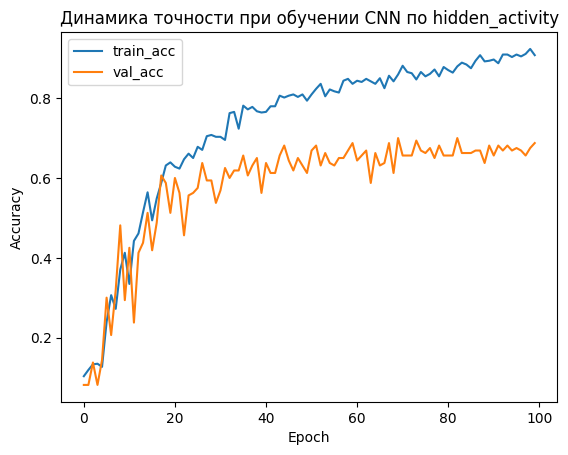

In [6]:
hidden_activity = []
for idx in range(num_samples):
    start_idx = idx * num_time_steps_per_sample
    end_idx = (idx + 1) * num_time_steps_per_sample
    mean_activity = np.mean(mon_hidden.v[:, start_idx:end_idx], axis=1)
    hidden_activity.append(mean_activity)
    
hidden_activity = np.array(hidden_activity)
y_labels = np.array(digits_audio)
mask = ~np.isnan(hidden_activity).any(axis=1)
hidden_activity_clean = hidden_activity[mask]
y_labels_clean = y_labels[mask]
unique_labels = np.unique(y_labels_clean)
X_cnn = hidden_activity_clean[:, :, np.newaxis]
X_train_cnn, X_test_cnn, y_train_cnn, y_test_cnn = train_test_split(
    X_cnn, y_labels_clean, test_size=0.2, random_state=42, stratify=y_labels_clean
)
input_layer = Input(shape=(X_train_cnn.shape[1], 1), name='hidden_activity_input')

x = Conv1D(filters=32, kernel_size=3, activation='relu', padding='same')(input_layer)
x = MaxPooling1D(pool_size=2)(x)
x = Conv1D(filters=64, kernel_size=3, activation='relu', padding='same')(x)
x = MaxPooling1D(pool_size=2)(x)
x = Flatten()(x)

output_layer = Dense(len(unique_labels), activation='softmax')(x)

model_cnn = Model(inputs=input_layer, outputs=output_layer)
model_cnn.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

model_cnn.summary()

history = model_cnn.fit(X_train_cnn, y_train_cnn,
                        epochs=100,
                        batch_size=128,
                        validation_split=0.2,
                        verbose=1)

y_pred_cnn = model_cnn.predict(X_test_cnn)
y_pred_classes = np.argmax(y_pred_cnn, axis=1)
test_acc = accuracy_score(y_test_cnn, y_pred_classes)
print(f"Точность CNN на тестовой выборке: {test_acc*100:.2f}%")

plt.plot(history.history['accuracy'], label='train_acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Динамика точности при обучении CNN по hidden_activity')
plt.legend()
plt.show()